for a specified file will find the timesteps at which each rat "socially gazes" at the other rat. need to specifify the assumed scope and radius of the rat's feild of vision. 

## load data

In [1]:
#Import packages
import scipy
import h5py
import numpy as np
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

In [2]:
#Set directory and check by printing
os.chdir('/gpfs/radev/pi/saxena/aj764/PairedTestingSessions/041924_KL002_TimeOut/Tracking/h5/')
print(os.getcwd())

/gpfs/radev/pi/saxena/aj764/PairedTestingSessions/041924_KL002_TimeOut/Tracking/h5


In [3]:
defaultdir = '/gpfs/radev/pi/saxena/aj764'
rootdir = f'{defaultdir}/PairedTestingSessions/'

In [4]:
filename ='041924_Cam4_TrNum5_Coop_KL002B-KL002Y.predictions.h5'

In [5]:
#Check file and file values
with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===filename===
041924_Cam4_TrNum5_Coop_KL002B-KL002Y.predictions.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(20262, 5, 2, 2)

===nodes===
0: nose
1: earL
2: earR
3: headBase
4: tailBase



In [6]:
frame_count, node_count, _, instance_count = locations.shape

print("frame count:", frame_count)
print("node count:", node_count)
print("instance count:", instance_count)

frame count: 20262
node count: 5
instance count: 2


## helper functions

In [7]:
x_min, x_max, y_min, y_max = min(locations[:, :, 0, :].reshape(-1)), max(locations[:, :, 0, :].reshape(-1)), min(locations[:, :, 1, :].reshape(-1)), max(locations[:, :, 1, :].reshape(-1))

In [8]:
def in_circle(point, circle):
    origin, radius = circle
    dist = np.sqrt((point[0] - origin[0]) ** 2 + (point[1] - origin[1]) ** 2)
    return dist < radius

In [9]:
def in_lines(points, nose):
    degs = []
    for point in points:
        # print(point)
        vec = point - nose
        # print(vec)
        deg = (math.degrees(math.atan(vec[1]/vec[0])))
        # print(deg)
        
        # this will be in quadrant 1 or quadrant 4
        # if the point is in quadrant 2 or 3... then need to translate
        if (point[0] - nose[0]) < 0:
            deg = 180 + deg 
        # print(deg)
        
        if deg < 0:
            deg += 360
        # print(deg)
        degs.append(deg)
    return degs[0] < degs[1] and degs[0] > degs[2]

In [17]:
def plot_fov(nose, head_base, other_rat, other_point1, other_point2 , vec, frame, rat, equal=False):
    colors = ['tab:orange', 'tab:blue']
    color = colors[rat]
    # plotting rat points and rat "body"
    plt.plot(other_rat[0], other_rat[1], '.', color=colors[rat-1], label='other rat')
    plt.plot(nose[0], nose[1], '.', color=color, label=node_names[0])
    plt.plot(head_base[0], head_base[1], '.', color=color, label=node_names[3])
    plt.plot([head_base[0], head_base[0] + vec[0]], [head_base[1], head_base[1] + vec[1]], color=color)
    # plt.legend()

    # plotting the other points
    plt.plot([nose[0], other_point1[0]], [nose[1], other_point1[1]], color=color)
    plt.plot([nose[0], other_point2[0]], [nose[1], other_point2[1]], color=color)
    plt.plot(other_point1[0], other_point1[1], '.', color=color)
    plt.plot(other_point2[0], other_point2[1], '.', color=color)

    
    plt.xlim(x_min + 50, x_max + 50)
    plt.ylim(y_min + 50, y_max + 50)
    if equal:
        plt.axis('equal')
        plt.gca().set_aspect("equal")
    
    # circle
    t = np.linspace(0, 360, 120)
    x = vis_radius * np.cos(t) + nose[0]
    y = vis_radius * np.sin(t) + nose[1]
    plt.plot(x,y, '.', color=color)
    plt.grid()

## find timesteps of social gaze

In [27]:
vis_scope = 45 # degree scope of field of vision
vis_radius = 300 # pixel distance of field of vision
graph_frame = 100 # graph = False

rat 1 socially gazed at 271 timesteps
rat 2 socially gazed at 207 timesteps


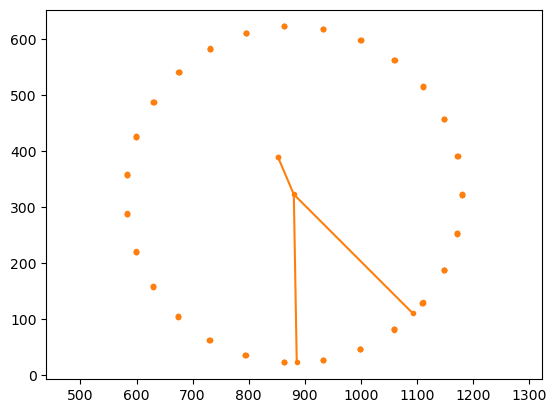

In [28]:
social_gaze = {}
# find social gaze timesteps for each rat
for rat in range(locations.shape[3]):
    if rat not in social_gaze.keys():
        social_gaze[rat] = []

    # check each from for social gaze
    for frame in range(locations.shape[0]):
        # get relevant body positions for both rats
        other_rat = locations[frame, 3, 0, rat-1], locations[frame, 3, 1, rat-1] # estimating other rat position from headbase
        nose = locations[frame, 0, :, rat]
        head_base = locations[frame, 3, :, rat]

        # find gaze direction
        vec = nose - head_base
        rad_add = math.atan(vec[1]/vec[0])
        if (vec[0]) < 0:
            rad_add = np.pi + rad_add    
        if rad_add < 0:
            rad_add += 2 * np.pi

        # find bounds of gaze
        other_point1 = [nose[0] + vis_radius * math.cos(rad_add + math.radians(vis_scope // 2)), nose[1] + vis_radius * math.sin(rad_add + math.radians(vis_scope // 2))]
        other_point2 = [nose[0] + vis_radius * math.cos(rad_add - math.radians(vis_scope // 2)), nose[1] + vis_radius * math.sin(rad_add - math.radians(vis_scope // 2))]

        # graph rat's feild of vision
        if frame == graph_frame: # graph:
            plot_fov(nose, head_base, other_rat, other_point1, other_point2, vec, frame, rat, equal=True)

        # check if other rat is in current rat's feild of vision
        if in_circle(other_rat, (nose, vis_radius)) and in_lines((other_rat, other_point1, other_point2), nose):
            social_gaze[rat].append(frame)
for rat in social_gaze.keys():
    print(f'rat {rat + 1} socially gazed at {len(social_gaze[rat])} timesteps')

## graph social gaze moments with rat position

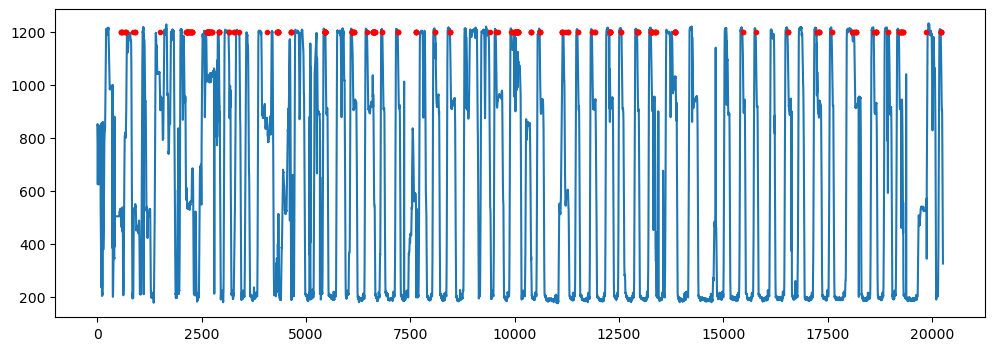

In [28]:
rat = 0
plt.figure(figsize=(12, 4))
plt.plot(locations[:, 3, 0, rat])
for gaze in social_gaze[rat]:
    plt.plot(gaze, 1200, '.', color='r')

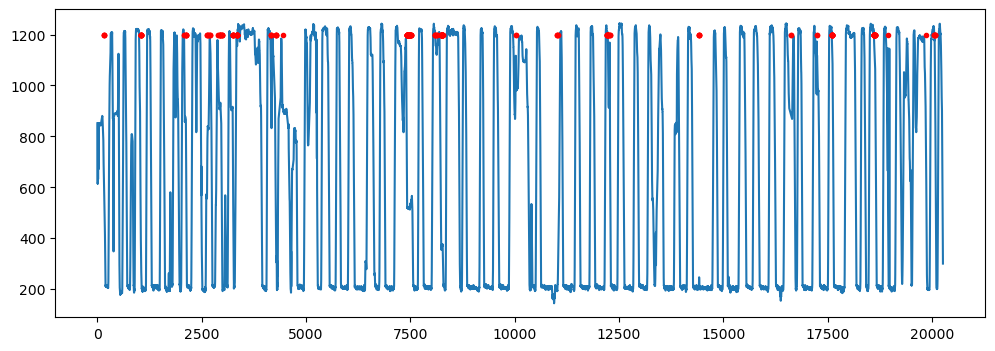

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(locations[:, 3, 0, rat])
for gaze in social_gaze[rat]:
    plt.plot(gaze, 1200, '.', color='r')